# Modern Numerical Methods

An interactive presentation using Python

manos.venardos@gmail.com

# Agenda
- Introduction
- Payoff & Density Differentiation
- Dependency Graphs
- Automatic Differentiation
- Machine Learning

Using many standard 3rd party libraries, and purpose-built analytics.

In [1]:
#Numerics & Analytics
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
import pydot

#Graphs & widgets
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from IPython.display import Image, display, clear_output, HTML

#Option Pricing
import black_scholes as bs_model
import implied_vol as iv_model

In [2]:
%matplotlib inline

# Introduction

Risk management of derivatives businesses requires significant computational resources and advanced numerical methods in order to compute the plethora of risk and PnL measures required.

Consider a path-dependent option on a basket of $\#N_U$ underlyings, requiring $\# N_T$ points the path. Such a product is valued with Monte Carlo methods simulating $\# N_P$ independent paths

$$
\hat{V} = \frac{1}{N_P} \sum_{p=1}^{N_P} \Pi(S(p))
$$

where $\Pi$ is the payoff at maturity and $S(p)$ the p-th simluated collection of asset paths. Typically 10s or 100s of thousands of path are simulated for this to reliably converge.

The cost of 1 valuation scales linearly with $N_P$ and is approximately given by

$$
c_V = c_f + \left(N_U \times N_T \times c_{\omega} + c_{\Pi} \right) \times N_P
$$
where
- $c_f$ is the fixed cost of setting up the simulation, due to e.g. a calibration
- $c_{\omega}$ is the cost of generating 1 random normal variate
- $c_{\Pi}$ is cost of evaluating the payoff at expiry, given the simulated asset paths

We employ the multi-asset Black scholes model and assume interest rates and interim payments are zero. Each asset has a volatility $\Sigma_u$ and the correlation matrix is $\rho$. The dynamics are in vector form given by

$$dS = C S dW$$

where $CC' = diag (\Sigma) \times \rho \times diag(\Sigma)$. Of interest are the parameters $S_0 \in \Re ^{N_U}$, $\Sigma \in \Re_+^{N_U}$ and $\rho \in \Re^{{N_U} \times {N_U}}$.

Risk Management involves 
- The calculation of numerous ***risk sensitivities***
- Trade re-valuation under different ***scenarios***

Of interest are $\tfrac{\partial V}{\partial S_0} \in \Re^{N_U}$, $\tfrac{\partial V}{\partial \Sigma} \in \Re^{N_U}$,  $\tfrac{\partial V}{\partial \rho} \in \Re^{N_U \times N_U}$ of which only $\tfrac{1}{2}N_U(N_U-1)$ are needed, and $\tfrac{\partial^2 V}{\partial S_0^2} \in \Re^{N_U\times N_U}$ of which only $\tfrac{1}{2}N_U(N_U+1)$ are needed. When using finite differences

\begin{eqnarray}
\frac{\partial V}{\partial \theta} & \sim & \frac{V(\theta + \delta) - V(\theta - \delta)}{2\delta} \\
\frac{\partial^2 V}{\partial \theta^2} & \sim & \frac{V(\theta + \delta) -2V(\theta) + V(\theta - \delta)}{\delta^2}
\end{eqnarray}

the total computational cost amounts to $2N_U(2+2N_U)\times c_V$.

We are also interested in valuing the trade under $\# N_S$ different scenario shocks $(\delta_n^{S_0}, \delta_n^{\Sigma}, \delta_n^{\rho})_{n\leq N_S}$. 

The total computational cost of valuation, risk measures and scenarios is
$$
C = (1 + 2N_U(2+N_U) + N_S)\times c_V
$$

And if we are interested in 
- Equidistand spot price scenarios in the hypercube, in which case $\ln N_S \sim o(N_U)$
- Calculating risk measuers in such a hypercube, in which each scenario requires $o(N_U)$ or $o(N_U^2)$ valuations

It gets very costly, very soon.

Need efficient techniques for risk measures and scenarios.

In [3]:
def bs_diffusion(rate, spots, vols, correls, timepoints, N, seed = None):
    if seed is not None:
        np.random.seed(seed)
    
    spots = np.asarray(spots);  vols = np.asarray(vols);  correls = np.asarray(correls);  timepoints = np.asarray(timepoints)
    ts = np.insert(timepoints, 0, 0.0)
    dt = np.diff(ts)
    
    shocks = np.random.multivariate_normal([0.0]*len(spots), correls, (N, len(timepoints)))
    drift = np.transpose(np.transpose(np.tile(rate - 0.5 * vols**2, (len(dt), 1))) * dt)
    vol = np.transpose(np.transpose(np.tile(vols, (len(dt), 1))) * np.sqrt(dt))
    
    dlogspot = drift + vol * shocks
    spot = spots * np.exp(np.cumsum(dlogspot, axis = 1))
    spot = np.insert(spot, 0, spots, axis = 1)
    
    return spot

We simulate correlated paths across 5 assets

In [4]:
%%time
rate = 0.02
spots = [100] * 5
vols = [0.16] * 5
corrs = np.full((5,5), 0.7)
np.fill_diagonal(corrs, 1.0)
timepoints = np.linspace(0.1, 2.0, 20)
N = 1000

p = bs_diffusion(rate, spots, vols, corrs, timepoints, N)

CPU times: user 52.4 ms, sys: 44 ms, total: 96.3 ms
Wall time: 103 ms


In [5]:
time = np.append(0.0, timepoints)

def eigsorted(cov):
    vals, vecs = np.linalg.eig(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]
    

def create_ellipse_for_scatter(x, y, nstd):
    mu1 = np.average(x)
    mu2 = np.average(y)
    v1 = np.std(x)
    v2 = np.std(y)
    cov = np.cov(x, y)
    
    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    
    w, h = nstd * nstd * np.sqrt(vals)
    ell = Ellipse((np.mean(x), np.mean(y)), w, h, theta, edgecolor='r', fc='None', lw=2)
    return ell
    

def plot_bs_diffusion(time, spot_paths):
    fig1, ((ax1_1, ax1_2), (ax1_3, ax1_4)) = plt.subplots(2, 2, figsize=(20,10))
    
    #Asset 1, different paths
    ax1_1.plot(time, spot_paths[0,:,0], color = 'b', label = 'Path 1')
    ax1_1.plot(time, spot_paths[1,:,0], color = 'r', label = 'Path 2')
    ax1_1.plot(time, spot_paths[2,:,0], color = 'g', label = 'Path 3')
    ax1_1.set_title('Asset 1')
    ax1_1.legend()

    #Path 1, different assets
    ax1_2.plot(time, spot_paths[0,:,0], color = 'b', label = 'Asset 1')
    ax1_2.plot(time, spot_paths[0,:,1], color = 'r', label = 'Asset 2')
    ax1_2.plot(time, spot_paths[0,:,2], color = 'g', label = 'Asset 3')
    ax1_2.set_title('Path 1')
    ax1_2.legend()

    lr10 = np.log(spot_paths[:,1,0] / spot_paths[:,0,0])
    lr11= np.log(spot_paths[:,1,1] / spot_paths[:,0,1])
    lr20 = np.log(spot_paths[:,2,0] / spot_paths[:,1,0])
    
    #Scatter Asset 1 vs Asset 2 log-returns in period 1 - should be as per input coefficient
    ax1_3.scatter(lr10, lr11, color = 'b')
    ellipse1_3_1 = create_ellipse_for_scatter(lr10, lr11, 1)
    ellipse1_3_2 = create_ellipse_for_scatter(lr10, lr11, 2)
    ax1_3.add_patch(ellipse1_3_1)
    ax1_3.add_patch(ellipse1_3_2)
    ax1_3.set_title('Period 1 Log Returns')
    ax1_3.set_xlabel('Asset 1')
    ax1_3.set_ylabel('Asset 2')

    #Scatter Asset 1 log-returns between period 1 & 2 - should be independent
    ax1_4.scatter(lr10, lr20, color = 'b')
    ellipse1_4_1 = create_ellipse_for_scatter(lr10, lr20, 1)
    ellipse1_4_2 = create_ellipse_for_scatter(lr10, lr20, 2)
    ax1_4.add_patch(ellipse1_4_1)
    ax1_4.add_patch(ellipse1_4_2)
    ax1_4.set_title('Asset 1 Log Returns')
    ax1_4.set_xlabel('Period 1')
    ax1_4.set_ylabel('Period 2')
    
    plt.show()
    
    return

And look at their statistical properties.

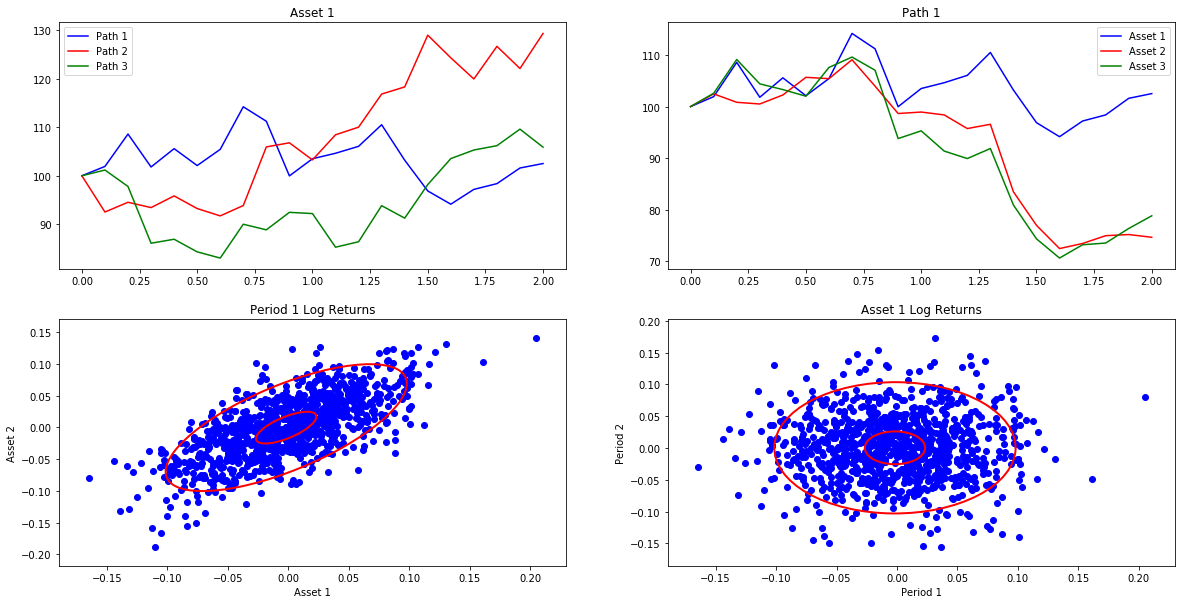

In [6]:
plot_bs_diffusion(time, p)

# Risk Sensitivities

We focus on computing the quantity

$$
\frac{\partial V}{\partial \theta} = \frac{\partial}{\partial \theta} E_0^Q \left[PV_0(T) \Pi(S) \right]
$$

where $S$ is in vector form the set of spot prices across assets and timepoints that the payoff depends on, and $\theta$ is a model related quantity.

We discuss 2 methods as an alternative to Finite Difference approximation
- Payoff differentiation
- Density differentiation

## Payoff Differentiation

We interpret the simulated asset paths as a function of model quantities $\theta$, so that

$$
\frac{\partial}{\partial \theta} PV_0(T) E_0^Q \left[\Pi(S(\theta)) \right] = PV_0(T) E_0^Q \left[\frac{\partial \Pi(S)}{\partial S} \frac{\partial S}{\partial \theta} \right]
$$

assuming $\Pi$ is well-behaved. 

Here, $\tfrac{\partial \Pi(S)}{\partial S} \in \Re^{N_U \cdot N_T}$ and $\tfrac{\partial S}{\partial \theta}$ is a path derivative.

In the single asset BS case, $\ln S_t = \ln S_0 + \left(r-\tfrac{1}{2} \Sigma^2\right) t + \Sigma W_t$ and it is straight-forward to deduce

\begin{eqnarray}
\frac{\partial S_t}{\partial S_0} & = & \frac{S_t}{S_0} \\
\frac{\partial S_t}{\partial \Sigma} & = & S_t \times \left(-\Sigma t + W_t \right)
\end{eqnarray}

Generalising to more general diffusions is possible but requires significantly more complicated frameworks e.g. see Malliavin calculus.

For a single asset Asian option $\Pi(S) = \max (A_T - K, 0)$ where $A_T = \tfrac{1}{N_T}\sum_{t=1}^{N_T} S_t$

$$
\frac{\partial \Pi(S)}{\partial S} = \frac{1_{A_T > K}}{N_T} \times \mathbb{1} \in \Re^{N_T}
$$

Therefore

\begin{eqnarray}
\frac{\partial V}{\partial S_0} & = & PV_0(T) E_0^Q \left[\frac{1_{A_T > K}}{S_0} A_T \right] \\
\frac{\partial V}{\partial \Sigma} & = & PV_0(T) E_0^Q \left[\frac{1_{A_T > K}}{N_T} \sum_{t=1}^{N_T} S_{t_i} \times \left(-\Sigma (t_i - t_{i-1}) + (W_t - W_{t-1}) \right) \right]
\end{eqnarray}

where $\tfrac{\partial A}{\partial S_t}$ is the sensitivity to a single summand $S_t$, with all other summands $S_{t^*}, t^* \neq t$ fixed.

In summary, 
- Each risk measure is an expected value, and the computational cost is half what FD requires
- It works for simple continuous payoffs for which we can calculate the vector derivative $\tfrac{\partial\Pi(S)}{\partial S}$ e.g. call, put, Asian. But will not work for discontinuous payoffs e.g. digital option
- It works for simple models for which we can compute the vector path derivative $\tfrac{\partial S}{\partial\theta}$. This generalises to more complex models, but needs significantly more advanced techniques

Note that the expectation $E_0^Q[]$ is taken w.r.t. the underlying stochastic normal process $\left\{ W \right\}_{0 \leq t \leq T}$ whose probability distribution is independent of $\theta$.

## Density Differentiation

An alternative angle is to express the valuation as an integration over the risk neutral probability density $q$ of the spot process $\left\{S \right\}_{0 \leq t \leq T}$, which is now itself a function of $\theta$

$$
\frac{\partial}{\partial \theta} PV_0(T)  \int \Pi(S) q(S|\theta) dS = PV_0(T)  \int \Pi(S) \frac{\partial q(S|\theta)}{\partial \theta} dS
$$

Since $\tfrac{dy}{dx} = \tfrac{d \ln y}{dx} y$, we express this as

$$
PV_0(T)  \int \Pi(S) \frac{\partial q(S|\theta)}{\partial \theta}dS = PV_0(T)  \int \Pi(S) \frac{\partial \ln q(S|\theta)}{\partial \theta} q(S|\theta)dS
$$

For the single asset BS case, $S_T$ is distributed as

$$
q(S|\theta) = \frac{1}{S\Sigma \sqrt{T}} \phi\left(\frac{\ln \tfrac{S}{K} - \left(r-\tfrac{\Sigma^2}{2}\right)T}{\Sigma \sqrt{T}}\right)
$$

and from which we can calculate

\begin{eqnarray}
\frac{\partial \ln q(S|S_0)}{\partial S_0} & = & \frac{\ln \tfrac{S}{S_0} - \left(r-\tfrac{\Sigma^2}{2}\right)T}{S_0 \Sigma^2 T}
\end{eqnarray}

In summary, 
- Each risk measure is an expected value, and the computational cost is half what FD requires
- It works for all payoffs
- It works for simple models for which we can compute the desnity derivative $\tfrac{\partial \log q}{\partial\theta}$

# Quiz 1 - Payoff Vs Density Differentiation

Which of the below statements is incorrect for a call option

1. When using path differentiation, the Delta estimate converges to a positive value as $N_P$ increases
2. When using path differentiation, the Delta is positive in each path $p$
3. When using density differentiation, the Delta estimate converges to a positive value as $N_P$ increases
4. When using desnity differentiation, the Delta is positive in each path $p$
5. With either technique, OTM paths contribute 0 to Delta

In [7]:
def mc_option_delta_by_path(spot, vol, rate, strike, texp, pt, nb_paths, seed = None):
    if pt not in [bs_model.CALL, bs_model.PUT]:
        raise Exception('Unrecognized payoff type: ' + pt)
        
    pv = np.exp(-rate*texp)
    
    epsilon = 0.01
    
    sp = bs_diffusion(rate, [spot], [vol], [[1.0]], [texp], nb_paths, seed)[:,-1,0]
    spd = bs_diffusion(rate, [(1.0-epsilon) * spot], [vol], [[1.0]], [texp], nb_paths, seed)[:,-1,0]
    spu = bs_diffusion(rate, [(1.0+epsilon) * spot], [vol], [[1.0]], [texp], nb_paths, seed)[:,-1,0]
    
    op = pv * bs_model.option_intrinsic_value(sp, strike, pt)
    opd = pv * bs_model.option_intrinsic_value(spd, strike, pt)
    opu = pv * bs_model.option_intrinsic_value(spu, strike, pt)
    
    fdds = (opu - opd) / (2.0*epsilon*spot)
    if pt == bs_model.CALL:
        dpds = sp / spot * pv * np.where(sp > strike, 1.0, 0.0)
    else:
        dpds = -sp / spot * pv * np.where(sp < strike, 1.0, 0.0)
    ddds = op * (np.log(sp/spot) - (rate - 0.5*vol**2)*texp) / (spot * vol**2 * texp)
    
    return (fdds, dpds, ddds)

def mc_option_delta(spot, vol, rate, strike, texp, pt, nb_paths, seed = None):
    (fdds, dpds, ddds) = mc_option_delta_by_path(spot, vol, rate, strike, texp, pt, nb_paths, seed)
    
    fdd = np.average(fdds)
    dpd = np.average(dpds)
    ddd = np.average(ddds)
    
    return (fdd, dpd, ddd)

In [8]:
def plot_option_deltas(spot, vol, rate, strike, texp, pt, nb_paths, seed = None):
    if pt not in [bs_model.CALL, bs_model.PUT]:
        raise Exception('Unrecognized payoff type: ' + pt)
        
    nb_conv = 20
    if nb_paths % nb_conv != 0:
        raise Exception('Number of paths should be multiple of ' + str(nb_conv) + ': ' + str(nb_paths))
    
    if pt == bs_model.CALL:
        bins = np.linspace(-1.0, 2.0, 50)
    else:
        bins = np.linspace(-2.0, 1.0, 50)
        
    theo_delta = bs_model.option_risk(spot, vol, rate, strike, texp, pt)['Delta']
    
    (fdds, dpds, ddds) = mc_option_delta_by_path(spot, vol, rate, strike, texp, pt, nb_paths, seed)
    
    deltas = []
    for n in range(1, nb_conv):
        idx = int(nb_paths*n/nb_conv)
        deltas.append((idx, theo_delta, np.average(fdds[0:idx]), np.average(dpds[0:idx]), np.average(ddds[0:idx])))
        
    fig2 = plt.figure(figsize=(20, 10))
    fig2.suptitle('Estimating Delta for a European ' + pt, fontsize=16)
    gs2 = fig2.add_gridspec(3, 2)
    
    #Finite difference delta histogram
    fdd_m = np.average(fdds)
    ax2_1 = fig2.add_subplot(gs2[0:1,0])
    ax2_1.hist(fdds, bins = bins, color = 'b', label = 'FD Deltas')
    ax2_1.axvline(x = fdd_m, label = 'Average Delta', color = 'r', lw=2)
    ax2_1.set_title('Finite Difference')
    ax2_1.legend()

    #Payoff differentiation delta histogram
    dpd_m = np.average(dpds)
    ax2_2 = fig2.add_subplot(gs2[1:2,0])
    ax2_2.hist(dpds, bins = bins, color = 'b', label = 'Payoff Diff Deltas')
    ax2_2.axvline(x = dpd_m, label = 'Average Delta', color = 'r', lw=2)
    ax2_2.set_title('Payoff differentiation')
    ax2_2.legend()

    #Density differentiation delta histogram
    ddd_m = np.average(ddds)
    ax2_3 = fig2.add_subplot(gs2[2:3,0])
    ax2_3.hist(ddds, bins = bins, color = 'b', label = 'Density Diff Deltas')
    ax2_3.axvline(x = ddd_m, label = 'Average Delta', color = 'r', lw=2)
    ax2_3.set_title('Density differentiation')
    ax2_3.legend()
    
    #Delta Convergence
    df = pd.DataFrame(deltas, columns=['NbPaths', 'Theo', 'FD', 'DP', 'DD'])
    df.set_index('NbPaths', inplace=True)
    ax2_4 = fig2.add_subplot(gs2[0:3,1])
    df.plot(ax=ax2_4, style='x-')
    ax2_4.set_title('Convergence Report')
    ax2_4.set_xlabel('Number of paths')
    ax2_4.set_ylabel('Delta Estimate')
    
    plt.show()
    
    return df

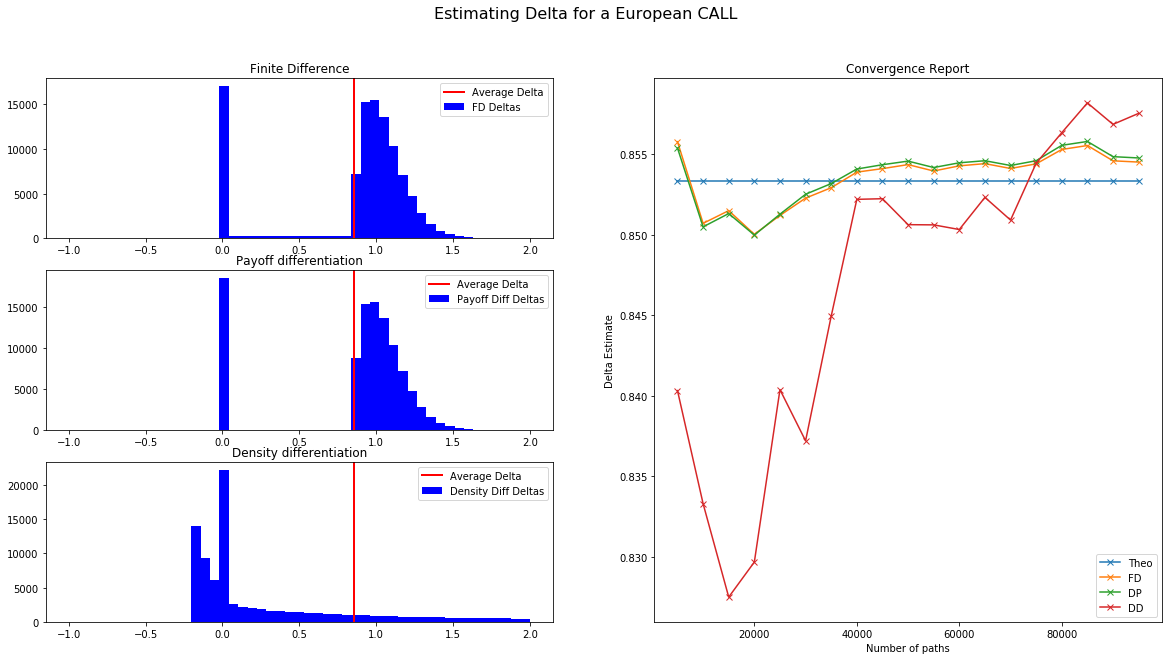

In [9]:
df = plot_option_deltas(100.0, 0.16, 0.05, 90.0, 1.0, 'CALL', 100000, 97)

# Dependency Graph

Sequence of relationships between intermediate variables and previous ones they depend on.

$$
y = f(x_1, x_2) = \log(x_1) (\log(x_1) + \sin(x_2))
$$

A likely implementation is

In [10]:
def f(x1, x2):
    v3 = np.log(x1)
    v4 = np.sin(x2)
    v5 = v3 + v4
    y = v3 * v5
    return y

In [11]:
def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

In [12]:
g = pydot.Dot(graph_type='digraph', rankdir='LR')

for nid in ['x1', 'x2']:
    g.add_node(pydot.Node(nid, fontcolor = 'black', fillcolor = 'green', style = 'filled', shape = 'square'))
    
for nid in ['y']:
    g.add_node(pydot.Node(nid, fontcolor = 'black', fillcolor = 'orange', style = 'filled', shape = 'square'))    
    
for nid in ['log', 'sin', '+', '*']:
    g.add_node(pydot.Node(nid, fontcolor = 'black', fillcolor = 'pink', style = 'filled'))

g.add_edge(pydot.Edge('x1', 'log', label = 'v1', labelangle = 45))
g.add_edge(pydot.Edge('x2', 'sin', label = 'v2'))
g.add_edge(pydot.Edge('log', '+', label = 'v3'))
g.add_edge(pydot.Edge('sin', '+', label = 'v4'))
g.add_edge(pydot.Edge('log', '*', label = 'v3'))
g.add_edge(pydot.Edge('+','*', label = 'v5'))
g.add_edge(pydot.Edge('*','y', label = 'v6'))

This is represented as a ***Directed Acyclic Graph*** (DAG) where the ***nodes*** represent the operations and the ***edges*** the data flow.

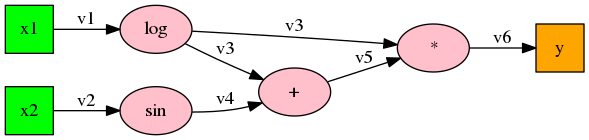

In [13]:
view_pydot(g)

The Excel calculation engine is based on such a concept
- It knows each cell's ancestors
- When `x2` changes, the nodes `sin`, `+` and `*` need to be recalculated
- But `log` is independent, so the current value of `v3` will be re-used for free

# Automatic Differentiation (AD)

AD is the programmatic logic that calculates the value of the derivative of a function (as opposed to the value of the function). AD isn't Symbolic Differentiation nor Numerical Differentiation.

Consider the DAG for `f` which consumes $x \in \Re^N$ and, via a sequence of intermediate operations, produces $y \in \Re^M$. AD is the code associated with computing

$$
\frac{dy}{dx} \in \Re^{N\times M}
$$

It should be possible because `f` ultimately uses elementary operations to transform vector variables to others i.e. $u_0 \rightarrow u_1 \rightarrow u_2 \rightarrow ... \rightarrow u_{K-1} \rightarrow u_K$.

# Quiz 2

In order to calculate the matrix product

$$
\underbrace{A}_{1 \times L} \times \underbrace{B}_{L \times M} \times \underbrace{C}_{M \times N}
$$

1. It is better to calculate $A\times(B\times C)$
2. It is better to calculate $(A\times B)\times C$
3. It makes no difference

# Quiz 3

In order to calculate the matrix product

$$
\underbrace{A}_{L \times M} \times \underbrace{B}_{M \times N} \times \underbrace{C}_{N \times 1}
$$

1. It is better to calculate $A\times(B\times C)$
2. It is better to calculate $(A\times B)\times C$
3. It makes no difference

## Forward Propagation

Denote by $\dot{u_n}$ the derivative of intermediate variable $u_n$ w.r.t. the input values $u_0$. Then

\begin{eqnarray}
\dot{u_{n+1}} & = & D_n \dot{u_n} \\
D_n & = & \frac{\partial u_{n+1}}{\partial u_n}
\end{eqnarray}

Therefore,

$$
\dot{u_K} = D_{K-1}D_{K-2}...D_1D_0\dot{u_0}
$$

Multiply iteratively from right to left. Nice and intuitive.

Note that
- Forward AD augments the `f` code with operations to calculate $D_i$ and $\dot{u_i}$, next to calculating $u_i$
- The augmented code is swept forward to simultaneously evaluate $f$ and $f'$
- To evaluate $\dot{u_K} \in \Re^{N\times M}$, $N$ re-runs of the augmented code are needed
- Setting $\dot{u_0}=(0,...,0,\underbrace{1}_{i\text{-th}},0,...,0)\in \Re^N$ will evaluate $\tfrac{\partial u_K}{\partial u_{0i}}\in \Re^M$
- Forward AD is efficient for $N<<M$

A likely implementation `f` is

In [14]:
def f(x1, x2):
    v3 = np.log(x1)
    v4 = np.sin(x2)
    v5 = v3 + v4
    y = v3 * v5
    return y

def f_dot_symbolic(x1, x2):
    t = np.log(x1)
    deriv = (2.0 * t/x1 + np.sin(x2)/x1, t * np.cos(x2))
    return deriv

Augment the code with variables to calculate the forward accumulation in a single forward sweep.

In [15]:
def f_dot_ad_fwd(x1, x2, x1_dot, x2_dot):
    #Forward sweep to calculate f, D and dot
    v1, v2 = x1, x2;                                         v1_dot, v2_dot = x1_dot, x2_dot
    v3 = np.log(v1);  dv3_dv1 = 1.0 / v1;                    v3_dot = dv3_dv1 * v1_dot
    v4 = np.sin(v2);  dv4_dv2 = np.cos(v2);                  v4_dot = dv4_dv2 * v2_dot
    v5 = v3 + v4;     dv5_dv3 = 1.0;         dv5_dv4 = 1.0;  v5_dot = dv5_dv3 * v3_dot + dv5_dv4 * v4_dot
    v6 = v3 * v5;     dv6_dv3 = v5;          dv6_dv5 = v3;   v6_dot = dv6_dv3 * v3_dot + dv6_dv5 * v5_dot
    
    return (v6, v6_dot)

Simple illustration

In [16]:
a = 2.19
b = 1.65

print("f: " + str(f(a, b)))
print("f' Symbolic: " + str(f_dot_symbolic(a, b)))

f: 1.3959456652101419
f' Symbolic: (1.1710813315574145, -0.062022986884674586)


In [17]:
print("f' AD_Fwd arg1: " + str(f_dot_ad_fwd(a, b, 1.0, 0.0)[1]))   #deriv=(1,0) for f' w.r.t arg1
print("f' AD Fwd arg2: " + str(f_dot_ad_fwd(a, b, 0.0, 1.0)[1]))   #deriv=(0,1) for f' w.r.t arg2

f' AD_Fwd arg1: 1.1710813315574145
f' AD Fwd arg2: -0.062022986884674586


Forward AD needs 2 sweeps to evaluate $f'$, one per input variable and using an appropriate $\dot{u_0}$ seed. 

But no extra sweeps would be needed if `f` returned multiple outputs.

# Backward Propagation

Denote by $\bar{u_n}$ the derivative of the output variable $u_K$ w.r.t. the intermediate variable $u_n$. Then

\begin{eqnarray}
\bar{u_n} & = & D^T_n \bar{u_{n+1}} \\
\end{eqnarray}

Therefore,

$$
\bar{u_0} = D^T_0 D^T_1...D^T_{K-2} D^T_{K-1}\bar{u_K}
$$

And multiply iteratively from right to left.

Note that
- Backward AD also augments the `f` code with operations to calculate $D_i$
- The augmented code is swept forward to evaluate $f$ and $D$, and then backwards for $f'$
- To evaluate $\bar{u_0} \in \Re^{N\times M}$, $M$ re-runs of the augmented code are needed
- Setting $\bar{u_K}=(0,...,0,\underbrace{1}_{i\text{-th}},0,...,0)\in \Re^M$ will evaluate $\tfrac{\partial u_{Ki}}{\partial u_0}\in \Re^N$
- Backward AD is efficient for $N>>M$

Augment the code with variables to calculate the backwards accumulation

In [18]:
def f_dot_ad_bwd(x1, x2, y_dot):
    #Forward sweep to calculate f and D, similar to Fwd AD (but no need to caclulate the dot)
    v1, v2 = x1, x2
    v3 = np.log(v1);   dv3_dv1 = 1.0 / v1
    v4 =  np.sin(v2);  dv4_dv2 = np.cos(v2)
    v5 = v3 + v4;      dv5_dv3 = 1.0;        dv5_dv4 = 1.0
    v6 = v3 * v5;      dv6_dv3 = v5;         dv6_dv5 = v3
    
    #Backward sweep to calculate bar
    v6_bar = y_dot
    v5_bar = dv6_dv5 * v6_bar
    v3_bar = dv6_dv3 * v6_bar + dv5_dv3 * v5_bar
    v4_bar = dv5_dv4 * v5_bar
    v2_bar = dv4_dv2 * v4_bar
    v1_bar = dv3_dv1 * v3_bar
    
    return (v6, (v1_bar, v2_bar))

Simple illustration

In [19]:
print("f: " + str(f(a, b)))
print("f' Symbolic: " + str(f_dot_symbolic(a, b)))

f: 1.3959456652101419
f' Symbolic: (1.1710813315574145, -0.062022986884674586)


In [20]:
print("f' AD_Bwd 1: " + str(f_dot_ad_bwd(a, b, 1.0)[1]))

f' AD_Bwd 1: (1.1710813315574145, -0.062022986884674586)


Backward AD needs 1 sweep to evaluate $f'$ for both inputs, and a single value of $\bar{u_0}$ seed. 

But extra sweeps would be needed if `f` returned multiple outputs.

## AD Implementations

Manually interleaving code for $\dot{u_i}$, $\bar{u_i}$ and $D_i$ inside the code for $f$ is error prone and complex. 

Software techniques have emerged to automate this process
- Source code transformation consumes the code for $f$ and produces the code for $f'$
- Graph libraries allow for calculations to be represented as a DAG, and offer significant toolkit to process these

The Black Scholes closed form looks like this in TensorFlow

In [21]:
def bs_call_option_price_cf_graph(graph):
    with graph.as_default():
        #Declare placeholders for the graph inputs
        S=tf.placeholder(tf.float32,name='S'); V=tf.placeholder(tf.float32,name='V'); K=tf.placeholder(tf.float32,name='K'); T=tf.placeholder(tf.float32,name='T')

        #The usual BS formula, but using tf. notation
        Phi = tf.distributions.Normal(0.0, 1.0).cdf
        var = V**2 * T;  sqrtvar = tf.sqrt(var)
        d1 = (tf.log(S/K) + var / 2.0) / sqrtvar;  d2 = d1 - sqrtvar
        price =  S * Phi(d1) - K * Phi(d2)

        #AD to the rescue
        m_risk_1 = tf.gradients(price, [S,V]);  p_risk = tf.gradients(price, [K,T]);  m_risk_2 = tf.gradients(m_risk_1[0], S)
        results = {'Price': price, 'Delta': m_risk_1[0], 'Gamma': m_risk_2[0], 'Vega': m_risk_1[1], 'dPrice_dK': p_risk[0], 'dPrice_dT': p_risk[1]}

    def calc(s, v, k, t):
        with graph.as_default(), tf.Session() as sess:
            return sess.run(results, {S: s, V: v, K: k, T: t})

    return calc

First, build the graph-based closed form pricer, once.

In [22]:
#Build the graph
bs_call_cf_graph = tf.Graph()
cf_pricer = bs_call_option_price_cf_graph(bs_call_cf_graph)

Then, invoke calculations with different arguments every time.

In [23]:
S = 100.0;  V = 0.16
K = 100.0;  T = 1.0; PT = bs_model.CALL

In [24]:
%%time
#Run the graph
print('AD CF Risk: ' + str(cf_pricer(S, V, K, T)))
print('CF Risk: ' + str(bs_model.option_risk(S, V, 0.0, K, T, PT)))

AD CF Risk: {'Price': 6.376278, 'Delta': 0.5318814, 'Gamma': 0.024854232, 'Vega': 39.766773, 'dPrice_dK': -0.46811864, 'dPrice_dT': 3.181342}
CF Risk: {'Price': 6.376274402797485, 'Delta': 0.5318813720139874, 'Gamma': 0.024854231594475557, 'Vega': 39.76677055116089}
CPU times: user 696 ms, sys: 7.82 ms, total: 704 ms
Wall time: 700 ms


In [25]:
def view_tf(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    strip_def = graph_def
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

In [26]:
view_tf(bs_call_cf_graph)

The Black Scholes monte carlo simulation looks like this in TensorFlow

In [27]:
def bs_call_option_price_mc_graph(graph):
    with graph.as_default():
        #Declare placeholders for the graph inputs
        S=tf.placeholder(tf.float32,name='S'); V=tf.placeholder(tf.float32,name='V'); K=tf.placeholder(tf.float32,name='K'); T=tf.placeholder(tf.float32,name='T')
        N=tf.placeholder(tf.int32,name='NbSims')

        #MC Simulation
        e = tf.random.normal((N, 1))
        S_T = S * tf.exp( (-V**2 / 2.0) * T + V * tf.sqrt(T) * e)
        C_T = tf.maximum(S_T[:,-1] - K, 0)
        price = tf.reduce_mean(C_T)

        #AD to the rescue - probably looks like payoff differentiation
        m_risk_1 = tf.gradients(price, [S,V]);  p_risk = tf.gradients(price, [K,T]);  
        results = {'Price': price, 'Delta': m_risk_1[0], 'Gamma': tf.constant('AD CANNOT COPE'), 'Vega': m_risk_1[1], 'dPrice_dK': p_risk[0], 'dPrice_dT': p_risk[1]}

    def calc(s, v, k, t, n):
        with graph.as_default(), tf.Session() as sess:
            return sess.run(results, {S: s, V: v, K: k, T: t, N: n})

    return calc

First, build the graph-based Monte Carlo pricer, once.

In [28]:
#Build the graph
bs_call_mc_graph = tf.Graph()
mc_pricer = bs_call_option_price_mc_graph(bs_call_mc_graph)

Then, invoke calculations with different arguments every time.

In [29]:
%%time
#Run the graph
print('AD MC Risk: ' + str(mc_pricer(S, V, K, T, 10000)))
print('CF Risk: ' + str(bs_model.option_risk(S, V, 0.0, K, T, PT)))

AD MC Risk: {'Price': 6.367797, 'Delta': 0.5241779, 'Gamma': b'AD CANNOT COPE', 'Vega': 39.769043, 'dPrice_dK': -0.46050322, 'dPrice_dT': 3.1815233}
CF Risk: {'Price': 6.376274402797485, 'Delta': 0.5318813720139874, 'Gamma': 0.024854231594475557, 'Vega': 39.76677055116089}
CPU times: user 115 ms, sys: 13 ms, total: 128 ms
Wall time: 124 ms


In [30]:
view_tf(bs_call_mc_graph)

## AD Performance

AD has gained significant popularity as a tool for calculating risk sensitivities
- Valuation models are ultimately a DAG with 100s of inputs (spot prices, volatilities, term structures etc.) and 1 output i.e. the price. AD backward propagation is very promising
- The computational cost tails off as the number of risk measures increases, in contrast to finite differences which increases linearly
- It requires a particular coding style and structure. Dedicated libraries have emerged to facilitate this, and some support hardware abstraction e.g. CPU vs GPU
- Discontinuities are a blocker, smoothing is a potential solution

# Machine Learning

The set of techniques a computer system is using in order to perform a task, without resorting to explicit instructions, but instead relying on patterns detected during training. 

Involves fitting a model in-sample, and then using it to make predictions out-of-sample.

The theory and algorithms behind ML are known for decades, but there is significant recent momentum due to
- Abundant and publicly available digital datasets to train the models e.g. the internet
- Abundant and affordable computational resources e.g. the cloud

Consider the familiar linear model

$$
y = X'\beta + \epsilon
$$

- Learning process: given a training dataset $(X_T, y_T)$, the fitted model parameters are $\hat{\beta} = (X'_TX_T)^{-1}X'_Ty_T$
- Prediction process: given an observed value $x_p$ and the fitted model $\hat{\beta}$, the prediction is $y_p = x'_p \hat{\beta}$
- Performing a task without explicit instructions, based on learnt patterns
- Used extensively across disciplines and contexts

Depending on the nature of the dependent variable $y$
- ***Regression*** models a continuous variable e.g. $y = $ price
- ***Classification*** models a discrete-valued variable e.g. $y=$ {cat, dog, neither}

Depending on the availability and use of training data
- ***Supervised*** learning works with a complete dataset $(X_T, y_T)$
- ***Semi-supervised*** learning allows for some training results $y_T$ to be missing
- ***Unsupervised*** learning only has access to $X_T$, and therefore focuses on data clustering and groupings
- ***Reinforcement*** learning receives a feedback rule from each prediction

A few ML models include
- Linear Models
- Artificial Neural Networks (ANN)
- Support Vector Machines (SVM)

The learning / fitting process employs a vast range of numerical algorithms, including steepest descent, least squares, genetic algorithms etc. 

## ANN Models

An interconnected set of neurons $n_{i,j}$ organised in layers $j\in\{1,2,..,J\}$ with $I(j)$ neurons per layer. Each $n_{i,j}$ accepts as inputs the outputs from ancestors $n_{k,j-1}$, and produces as output 

$$
o_{i,j} = A\left(\sum_{k=1}^{I(j-1)} \left(w_{i,j,k} \times o_{k, j-1} + w_{i,j,0}\right)\right)
$$

where $A$ is an activation function e.g. the logistic function $\tfrac{1}{1+e^{-x}}$, the hyperbolic tangent $\tanh(x)$ and the Rectified Linear Unit (ReLU) $\max(x,0)$. In this setup,
- $w_{i,j,k}$ are model parameters to be fitted as part of the learning process
- $J$, $I(j)$ and $A$ are the geometry of the neural network, typically fixed during the learning process

The Universal Approxmation Theorem for ANNs states that a continuous $f: [0,1]^N \rightarrow [0,1]^M$ can be arbitrarily well approximated by a single hidden layer feed-forward ANN, given a reasonable activation function. For example, the single layer ANN is

$$
f_{ANN}(x) = \sum_{k=1}^I v_k A(w_{k,1} x + w_{k,0})
$$

For a given $\epsilon>0$, there exist $I$, $A$, $w$ and $v$ such that $|f(x) - f_{ANN}(X)|<\epsilon$. 

So $f_{ANN}$ is dense in the space of continuous functions.

In [31]:
ann = pydot.Dot(graph_type='digraph', rankdir='UD')

inputs = ['x1', 'x2', 'x3']
outputs = ['y1', 'y2']
neurons1 = ['n1_1', 'n1_2', 'n1_3', 'n1_4', 'n1_5', 'n1_6']
neurons2 = ['n2_1', 'n2_2', 'n2_3', 'n2_4', 'n2_5', 'n2_6']

for nid in inputs:
    ann.add_node(pydot.Node(nid, fontcolor = 'black', fillcolor = 'green', style = 'filled', shape = 'circle'))
    
for nid in neurons1 + neurons2:
    ann.add_node(pydot.Node(nid, fontcolor = 'black', fillcolor = 'pink', style = 'filled', shape = 'circle'))    

for nid in outputs:
    ann.add_node(pydot.Node(nid, fontcolor = 'black', fillcolor = 'orange', style = 'filled', shape = 'circle'))

links = [(inputs, neurons1) , (neurons1, neurons2), (neurons2, outputs)]

for l in links:
    (ins, outs) = l
    for i in ins:
        for o in outs:
            ann.add_edge(pydot.Edge(i, o))

Illustration of an ANN with 2 hidden layers

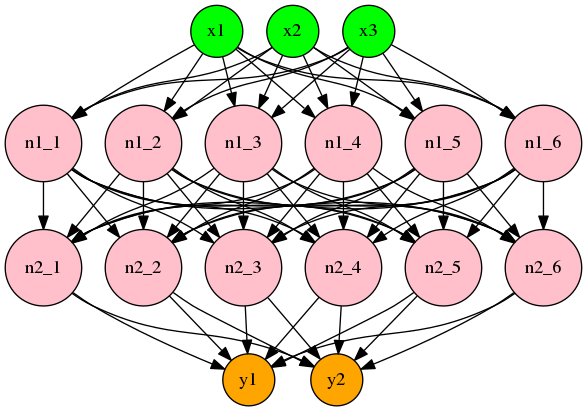

In [32]:
view_pydot(ann)

In [33]:
def random_market(base_market, means, vols, correls, nb_samples, seed = None):
    s, v, r = base_market
    
    if seed is not None:
        np.random.seed(seed)
    
    cov = np.matmul(np.diag(vols), np.matmul(correls, np.diag(vols)))

    random_market = np.random.multivariate_normal(means, cov, nb_samples)
    random_market[:,0] = s * np.exp(random_market[:,0])
    random_market[:,1] = v + random_market[:,1]
    random_market[:,2] = r + random_market[:,2]
    random_market = np.insert(random_market, 0, [s, v, r], axis=0)
    
    return random_market

def value_option(markets, strike, texp, pt):
    price = []
    for s, v, r in markets:
        pv = np.exp(-r * texp)
        fwd = s / pv
        price.append(bs_model.option_price(fwd, v, pv, strike, texp, pt))
    
    return np.asarray(price)

We illustrate the use of an ANN to learn the Black Scholes option pricing formula. First, create a training dataset $(\theta_T, c_T)$ where $\theta = [S, \Sigma, r]$ and $c$ is the analytic BS price. We sample $\theta$ as multi-variate normal shocks around their base values. 

In [34]:
means = np.asarray([0.0, 0.0, 0.0])
stdevs = np.asarray([V, 0.05, 0.02])
correls = np.asarray([[1.0, -0.7, 0.2], [-0.7, 1.0, 0.3], [0.2, 0.3, 1.0]])
R = 0.05

market_training = random_market([S, V, R], means, stdevs, correls, 1000, 97)
price_training = value_option(market_training, K, T, PT)

We then create the topology of an ANN, and fit it to the training dataset.

In [35]:
scaler = StandardScaler()
scaler.fit(market_training)
X_training = scaler.transform(market_training)

mlp = MLPRegressor(activation='tanh', solver='lbfgs')
mlp.fit(X_training, price_training)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='lbfgs', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [36]:
def plot_ml_performance(market_test, strike, texp, pt, mlp, scaler):
    X_test = scaler.transform(market_test)
    
    price_predict_exact = value_option(market_test, strike, texp, pt)
    price_predict_mlp = mlp.predict(X_test)
    print('R^2: ' + str(mlp.score(X_test, price_predict_exact)))
    error = price_predict_mlp - price_predict_exact
    
    bins = int(len(market_test) / 10.0)
    
    fig3, (ax3_1, ax3_2) = plt.subplots(1, 2, figsize=(20,7))
    fig3.suptitle('ML Performance for European ' + pt, fontsize=16)
    
    #MLP Histogram
    ax3_1.hist(error, bins = bins, color = 'b', label = 'MLP Errors')
    ax3_1.set_title('MLP Error')
    ax3_1.set_xlabel('Error')
    ax3_1.set_ylabel('Frequency')

    ax3_2.scatter(x = price_predict_exact, y = price_predict_mlp, marker = 'o', color = 'b', label = 'MLP')
    ax3_2.plot([price_predict_exact.min(), price_predict_exact.max()], [price_predict_exact.min(), price_predict_exact.max()], ls="-", color='r', label = 'BS')
    ax3_2.legend()
    
    plt.show()

We then create an out-of-sample set $\theta_P$ and analyse the prediction error.

R^2: 0.9999894887730484


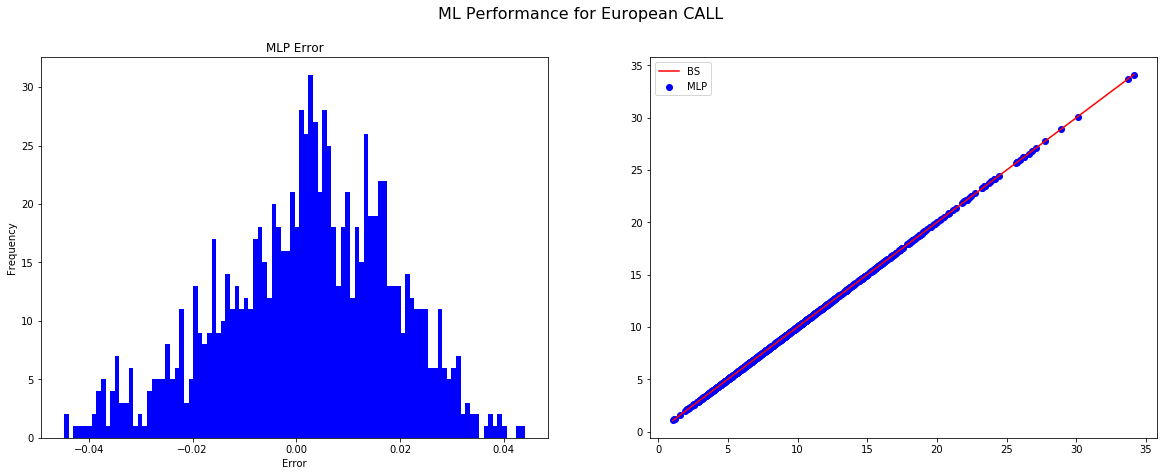

In [37]:
market_test = random_market([S, V, R], means, 0.5 * stdevs, correls, 1000, 98)
plot_ml_performance(market_test, K, T, PT, mlp, scaler)

In [38]:
def plot_ml_marginal_performance(base_market, strike, texp, pt, mlp, scaler):
    s, v, r = base_market
    
    spots = np.linspace(0.5*S, 1.5*S, 101)
    market_spot = [[s, V, R] for s in spots]
    price_spot_exact = value_option(market_spot, K, T, bs_model.CALL)
    price_spot_mlp = mlp.predict(scaler.transform(market_spot))

    vols = np.linspace(V-0.1, V+0.1, 101)
    market_vol = [[S, v, R] for v in vols]
    price_vol_exact = value_option(market_vol, K, T, bs_model.CALL)
    price_vol_mlp = mlp.predict(scaler.transform(market_vol))

    rates = np.linspace(R-0.01, R+0.01, 11)
    market_rate = [[S, V, r] for r in rates]
    price_rate_exact = value_option(market_rate, K, T, bs_model.CALL)
    price_rate_mlp = mlp.predict(scaler.transform(market_rate))
    
    fig4, (ax4_1, ax4_2, ax4_3) = plt.subplots(1, 3, figsize=(20,7))
    fig4.suptitle('ML Performance for European ' + pt, fontsize=16)
    
    #Spot dimension
    ax4_1.plot(spots, price_spot_exact, color = 'r', label = 'BS')
    ax4_1.plot(spots, price_spot_mlp, color = 'b', label = 'MLP')
    ax4_1.set_title('Spot Dimension')
    ax4_1.set_xlabel('Spot')
    ax4_1.set_ylabel('Price')
    ax4_1.legend()
    
    #Vol dimension
    ax4_2.plot(vols, price_vol_exact, color = 'r', label = 'BS')
    ax4_2.plot(vols, price_vol_mlp, color = 'b', label = 'MLP')
    ax4_2.set_title('Vol Dimension')
    ax4_2.set_xlabel('Vol')
    ax4_2.set_ylabel('Price')
    ax4_2.legend()
    
    #Rate dimension
    ax4_3.plot(rates, price_rate_exact, color = 'r', label = 'BS')
    ax4_3.plot(rates, price_rate_mlp, color = 'b', label = 'MLP')
    ax4_3.set_title('Rate Dimension')
    ax4_3.set_xlabel('Rate')
    ax4_3.set_ylabel('Price')
    ax4_3.legend()

    plt.show()

Finally, we create dedicated out-of-sample datasets spanning each model parameter independently, and benchmark the ANN vs the analytic formula.

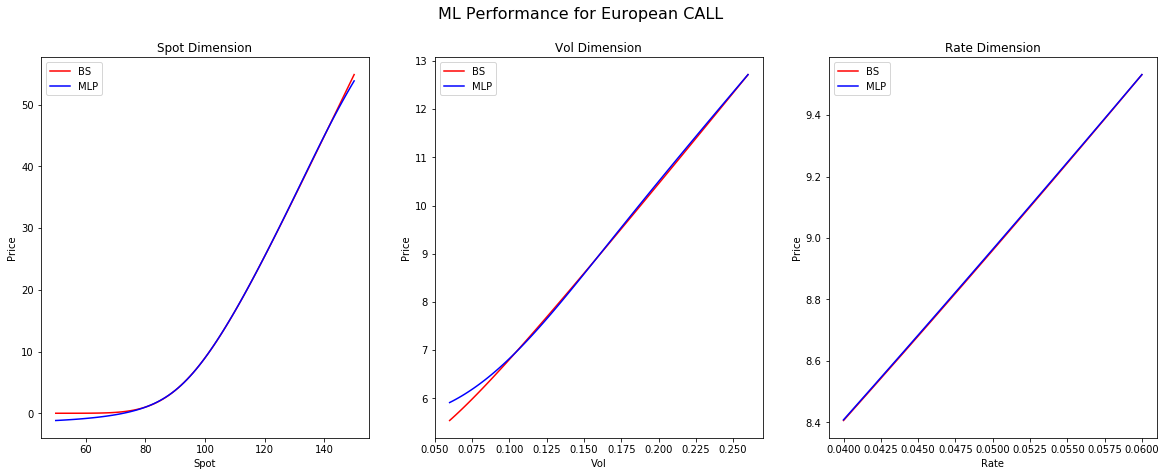

In [39]:
plot_ml_marginal_performance([S, V, R], K, T, PT, mlp, scaler)

ML models are highly commoditised nowadays
- They are available in many open-source libraries
- They can be used as services on the cloud, at low cost
- Their use appear straight-forward e.g. `model.fit(x_T, y_T); model.predict(x_P); model.score(x_P, y_P)`

ML models are essentialy DAGs. During the learning process, the optimizer needs to compute the derivative of an objective function w.r.t. the model parameters, so AD techniques are heavily employed.

Applications of ML in mathematical finance include
- As function approximations to complex valuation models
- Implied volatility parameterisation
- American Monte Carlo and early exercise decisions
- As approximators to PDE solutions
- Non-parametric hedging

With plenty more applications in financial services covering market making, statistical arbitrage, recommendation engines, middle and back office automation, chatbots etc.

With caveats
- The choice of the model matters i.e. the regressor or classifier type
- While a given regressor looks simple e.g. `MLPRegressor()`, it actually comes with a very long list of optional tuning parameters - and they matter
- Learning can require very large datasets
- Extrapolation can be problematic (interpolation too)

# Thank you for your attention!